In [1]:
import numpy as np
import json
from pathlib import Path
from os import listdir,getcwd,chdir,mkdir
chdir(str(Path('..//')))

In [2]:
from os.path import isfile,join,exists
import sys
sys.path.append(join(getcwd(),str(Path('src'))))
sys.path.append(join(getcwd(),str(Path('src/compression_funcs'))))
sys.path.append(join(getcwd(),str(Path('src/DataLoader'))))
sys.path.append(join(getcwd(),str(Path('src/Optimizer'))))
import glob
# import radam
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
# import Data_utils
# import chebyshev_compression as cheb
# import Adaptive_chebyshev_tests as cheb_tests
# import Adaptive_chebyshev as adp_cheb
# import Company_Loader as company_data_loader
# import MIT_BIH_Loader as ecg_data_loader
# import wfdb
# import REDD_Loader as power_data_loader
import scipy
%matplotlib inline
print(getcwd())
from MISC.stats_utils import calc_statistics
# sys.path.append(join(getcwd(),str(Path('src/Enviroments/ExternalEnv/BioSPPy'))))
# from LossyLessCompression import LossyLessCompression
# from Enviroments.ExternalEnv.BioSPPy import main
# from Enviroments.ExternalEnv.BioSPPy.biosppy.signals import ecg
from MISC.stats_utils import calc_loss_percentage_single,normelize_data,calc_PRD,calc_PRD_matrices,calc_entropy
from MISC.extra_utils import reshapeECG_data
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
from torch.utils import data
# from torch.utils.tensorboard import SummaryWriter
import MIT_BIH_Loader as mit_bih_loader
# import random
# from MIT_BIH_Loader import Dataset_MITBIH
# from Company_Loader import Dataset
# from wfdb import processing
# from Company_ENV_Loader import Dataset_ENV
# from scipy.interpolate import interp1d
# import copy
# from torchsummary import summary
# wfdb.dl_database('mitdb', os.path.join(os.getcwd(), 'Data/mitdb'))
# cudnn.benchmark = True
pd.set_option('display.max_colwidth',10000)
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device

/home/welad1992/thesis


In [3]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv1D, Flatten, Lambda,MaxPool1D,BatchNormalization,UpSampling1D,AveragePooling1D
from tensorflow.keras.layers import Reshape,Concatenate,ZeroPadding1D
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
import math
import numpy as np
import matplotlib.pyplot as plt
import argparse
import os

In [4]:
import tensorflow as tf

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

In [6]:
company_path_csv = join(getcwd(),str(Path(r'Data/TheCompany/csv/temp_company.csv')))
company_path_bin_decompressed = join(getcwd(),str(Path(r'Data/TheCompany/decompressed')))
company_path_bin = join(getcwd(),str(Path(r'Data/TheCompany')))

mit_bih_bin = join(getcwd(),str(Path(r'Data/mitdb')))
gas_path_bin = join(getcwd(),str(Path(r'Data/GAS')))
REDD_path_csv = join(getcwd(),str(Path(r'Data/REDD')))
TENSORBOARD_DIR = join(getcwd(),str(Path(r'Data/tensorsumery')))
data_path = company_path_bin
FACTOR = 4
WINDOW_SIZE = 2000

## Load cinc data

In [7]:
from Enviroments.ExternalEnv.EcgClassification.ecg import network,network_compression,network_compression_IoT
import Enviroments.ExternalEnv.EcgClassification.ecg.load as load
import Enviroments.ExternalEnv.EcgClassification.ecg.util as util


In [8]:
train = load.load_dataset("src/Enviroments/ExternalEnv/ecg-classification-AndrewNG/examples/cinc17/train.json")
preproc = load.Preproc(*train,app=True,CINC=True)

dev = load.load_dataset('src/Enviroments/ExternalEnv/ecg-classification-AndrewNG/examples/cinc17/dev.json')
train_gen = load.data_generator(32, preproc, *train)
dev_gen = load.data_generator(32,preproc, *dev)
#     plt.plot(x)
#     raise

100%|██████████| 852/852 [00:00<00:00, 5377.93it/s]


In [9]:
x_train,y_train = preproc.process(train[0],train[1])
x_train.shape,y_train[0].shape,y_train[1].shape

((5403, 8960, 1), (5403, 8960, 1), (5403, 35, 4))

In [10]:
x_dev,y_dev = preproc.process(dev[0],dev[1])
x_dev.shape,y_dev[0].shape,y_dev[1].shape

((602, 8960, 1), (602, 8960, 1), (602, 35, 4))

In [11]:
params_config = json.load(open(r'src/Enviroments/ExternalEnv/EcgClassification/examples/cinc17/config.json', 'r'))
params_config.update({
        "input_shape": [None, 1],
        "num_categories": len(preproc.classes),
        "loss_weights": [0.4,0.4,0.1,0.1]
    })

## Combine compression Network and Applicatino network

In [12]:
# # sliding_ae = network_compression.init_compress_app_network(build_comression_network_32CG_dropout,'Models/CAE_keras_200520.h5',params_config,compile=True)
# # thesis/Models/GoodModels/CAE_keras_32CG_200520.h5
# sliding_ae = network_compression.init_compress_app_network(network_compression.build_compression_network_16CG,"Models/GoodModels/CAE_MITBIH_16CG_4.834-5.328-0.000.hdf5",params_config,compile=True)
# sliding_ae.summary()
# sliding_ae = network_compression.init_compress_app_network(network_compression.u_net_16_32_iot,'Models/Progressive/U_NET_32-16_iot-[3.71][6.11].hdf5',params_config, compile=True, u_net=True)

In [13]:
# CAE_32 = load_model('Models/GoodModels/CG_32_CAE_CINC17_0.740-0.785.hdf5')
# CAE_64 = load_model('Models/GoodModels/CG_64+AppNet_1.048-0.545-006-0.762-0.694.hdf5')

## Analyze SkipNetwork

## IoT

In [14]:
model_ecg_classification = network.build_network(**params_config)

loading weights of:src/Enviroments/ExternalEnv/ecg-classification-AndrewNG/saved/cinc17/Best_Weight/0.387-0.866-014-0.276-0.901.hdf5


In [15]:
params_config['compile']=True

In [16]:
y_dev[1].shape

(602, 35, 4)

In [17]:
# model_ecg_classification.evaluate(x_dev,y_dev[1],verbose=False)

In [18]:

# model_ecg_classification = network.build_network(**params_config)
# network.add_compile(model_ecg_classification, **params_config)

# params_config.update({
#         "input_shape": [None, 1],
#         "num_categories": len(preproc.classes),
#         "loss_weights": [0.4,0.4,0.1,0.1]
#     })

# compression_methods = [
# #     FULLY TRAINED MODELS (compression+application)
#     { "compression_func":network_compression.u_net_16_32_iot,
#        "weights_path":'Models/GoodModels/CAE_unet_CINC17_w0.8_loss-0.590-ACC-0.848.hdf5',
#         "copmression_weight":""}
        
# #     FULLY TRAINED MODELS (compression+application)
# #     { "compression_func":network_compression.build_compression_network_16CG,
# #        "weights_path":'Models/GoodModels/CAE_CINC17CG16_loss-0.099-ACC-0.850.hdf5',
# #         "copmression_weight":""},
        
# #     {
# #         "compression_func":network_compression.build_comression_network_32CG,
# #        "weights_path":'Models/GoodModels/CAE_CINC17CG32_loss-0.355-ACC-0.772.hdf5',
# #         "copmression_weight":""
# #     },
# #     {
# #         "compression_func":network_compression.build_compression_network_64CG,
# #        "weights_path":'Models/GoodModels/CAE_CINC17CG64_loss-0.904-ACC-0.586.hdf5',
# #         "copmression_weight":""
# #     }
    
# #     #Each network trained SEPARATELY (compression+application)
# #     { "compression_func":network_compression.build_compression_network_16CG,
# #        "weights_path":'',
# #         "copmression_weight":"Models/GoodModels/CAE_MITBIH_16CG_4.834-5.328-0.000.hdf5"
# #     },    
# #     {
# #         "compression_func":network_compression.build_comression_network_32CG,
# #        "weights_path":'',
# #         "copmression_weight":"Models/GoodModels/CAE_MITBIH_32CG_6.578-5.686-0.001.hdf5"
# #     },
# #     {
# #         "compression_func":network_compression.build_compression_network_64CG,
# #        "weights_path":'',
# #         "copmression_weight":"Models/GoodModels/CAE_MITBIG_64CG_8.062-7.629-0.001.hdf5"
# #     }
# ]#,'Models/GoodModels/CG_64+AppNet_1.048-0.545-006-0.762-0.694.hdf5','Models/GoodModels/CAE_CINC17_loss:-0.099-ACC:-0.850.hdf5']#,CAE_32,CAE_64]

# stats = []
# # for idx,(signal,annotation) in enumerate(list(zip(x_dev,y_dev[1]))): #zip signal + annotation
# #     STD = np.std(signal)
# #     entropy = calc_entropy(signal)
# #     amp_size = np.abs(np.max(signal) - np.min(signal))
# #     accuracy = model_ecg_classification.evaluate(signal.reshape(1,8960,1),annotation.reshape(1,35,4),verbose=False)[1]
# #     #         PRD = calc_PRD(signal,decompressed)
# #     stats.append([idx,signal,accuracy,0,'no_copmression',STD,entropy,amp_size])

    
# # statistics on Unet_iot-32-64
# m = network_compression_IoT.init_compress_app_network(network_compression_IoT.u_net_32_64,'',params_config, compile=True, u_net=True)
# if compressor_path['weights_path']!="":
#     m.load_weights('Models/Progressive/UNET32-64-IoT_CINC17_w:0.8.hdf5')

# for idx,(signal,annotation) in enumerate(list(zip(x_dev,y_dev[1]))): #zip signal + annotation
#     STD = np.std(signal)
#     entropy = calc_entropy(signal)
#     amp_size = np.abs(np.max(signal) - np.min(signal))
#     _,mse_loss32,mse_loss64,_,_,accuracy32,accuracy64 = m.evaluate(signal.reshape(1,8960,1),[signal.reshape(1,8960,1),signal.reshape(1,8960,1),annotation.reshape(1,35,4),annotation.reshape(1,35,4)],verbose=False)
#     stats.append([idx,signal,accuracy32,mse_loss32,'unet_32CG',STD,entropy,amp_size])
#     stats.append([idx,signal,accuracy64,mse_loss64,'unet_64CG',STD,entropy,amp_size])
    
    
# for compressor_path in compression_methods:
#     m = network_compression.init_compress_app_network(compressor_path["compression_func"],compressor_path["copmression_weight"],params_config,compile=True,u_net=True)
#     if compressor_path['weights_path']!="":
#         m.load_weights(compressor_path['weights_path'])
    
#     for idx,(signal,annotation) in enumerate(list(zip(x_dev,y_dev[1]))): #zip signal + annotation
#         STD = np.std(signal)
#         entropy = calc_entropy(signal)
#         amp_size = np.abs(np.max(signal) - np.min(signal))
#         _,mse_loss16,mse_loss32,_,_,accuracy16,accuracy32 = m.evaluate(signal.reshape(1,8960,1),[signal.reshape(1,8960,1),signal.reshape(1,8960,1),annotation.reshape(1,35,4),annotation.reshape(1,35,4)],verbose=False)
#         stats.append([idx,signal,accuracy16,mse_loss16,'unet_16CG',STD,entropy,amp_size])
#         stats.append([idx,signal,accuracy32,mse_loss32,'unet_32CG',STD,entropy,amp_size])
#     print('done model')

## Full Network

In [19]:
import gc

In [20]:
model_ecg_classification = network.build_network(**params_config)
network.add_compile(model_ecg_classification, **params_config)
compression_methods = [
#     FULLY TRAINED MODELS (compression+application)
#     { "compression_func":network_compression.u_net_16_32_iot,
#        "weights_path":'Models/GoodModels/CAE_unet_CINC17_w0.8_loss-0.590-ACC-0.848.hdf5',
#         "copmression_weight":""}
        
#     FULLY TRAINED MODELS (compression+application)
    { "compression_func":network_compression.build_compression_network_16CG,
       "weights_path":'Models/GoodModels/CAE_CINC17CG16_loss-0.099-ACC-0.850.hdf5',
        "copmression_weight":""},
        
    {
        "compression_func":network_compression.build_comression_network_32CG,
       "weights_path":'Models/GoodModels/CAE_CINC17CG32_loss-0.355-ACC-0.772.hdf5',
        "copmression_weight":""
    },
    {
        "compression_func":network_compression.build_compression_network_64CG,
       "weights_path":'Models/GoodModels/CAE_CINC17CG64_loss-0.904-ACC-0.586.hdf5',
        "copmression_weight":""
    }
    
#     #Each network trained SEPARATELY (compression+application)
#     { "compression_func":network_compression.build_compression_network_16CG,
#        "weights_path":'',
#         "copmression_weight":"Models/GoodModels/CAE_MITBIH_16CG_4.834-5.328-0.000.hdf5"
#     },    
#     {
#         "compression_func":network_compression.build_comression_network_32CG,
#        "weights_path":'',
#         "copmression_weight":"Models/GoodModels/CAE_MITBIH_32CG_6.578-5.686-0.001.hdf5"
#     },
#     {
#         "compression_func":network_compression.build_compression_network_64CG,
#        "weights_path":'',
#         "copmression_weight":"Models/GoodModels/CAE_MITBIG_64CG_8.062-7.629-0.001.hdf5"
#     }
]#,'Models/GoodModels/CG_64+AppNet_1.048-0.545-006-0.762-0.694.hdf5','Models/GoodModels/CAE_CINC17_loss:-0.099-ACC:-0.850.hdf5']#,CAE_32,CAE_64]
params_config["loss_weights"]= [0.5,0.5]
stats = []
for idx,(signal,annotation) in enumerate(list(zip(x_dev,y_dev[1]))): #zip signal + annotation
    STD = np.std(signal)
    entropy = calc_entropy(signal)
    amp_size = np.abs(np.max(signal) - np.min(signal))
    loss,accuracy = model_ecg_classification.evaluate(signal.reshape(1,8960,1),annotation.reshape(1,35,4),verbose=False)
    #         PRD = calc_PRD(signal,decompressed)
    stats.append([idx,signal,accuracy,0,loss,'no_copmression',STD,entropy,amp_size])
    tf.keras.backend.clear_session()
    gc.collect()

for compressor_path in compression_methods:
    m = network_compression.init_compress_app_network(compressor_path["compression_func"],compressor_path["copmression_weight"],params_config,compile=True,u_net=False)
    if compressor_path['weights_path']!="":
        m.load_weights(compressor_path['weights_path'])
#     raise
    for idx,(signal,annotation) in enumerate(list(zip(x_dev,y_dev[1]))): #zip signal + annotation
        STD = np.std(signal)
        entropy = calc_entropy(signal)
        amp_size = np.abs(np.max(signal) - np.min(signal))
        _,mse_loss,app_loss,accuracy = m.evaluate(signal.reshape(1,8960,1),[signal.reshape(1,8960,1),annotation.reshape(1,35,4)],verbose=False)
        stats.append([idx,signal,accuracy,mse_loss,app_loss,m.layers[0].name,STD,entropy,amp_size])
        tf.keras.backend.clear_session()
        gc.collect()
print('done model')

loading weights of:src/Enviroments/ExternalEnv/ecg-classification-AndrewNG/saved/cinc17/Best_Weight/0.387-0.866-014-0.276-0.901.hdf5
loading weights of:src/Enviroments/ExternalEnv/ecg-classification-AndrewNG/saved/cinc17/Best_Weight/0.387-0.866-014-0.276-0.901.hdf5
loading weights of:src/Enviroments/ExternalEnv/ecg-classification-AndrewNG/saved/cinc17/Best_Weight/0.387-0.866-014-0.276-0.901.hdf5
loading weights of:src/Enviroments/ExternalEnv/ecg-classification-AndrewNG/saved/cinc17/Best_Weight/0.387-0.866-014-0.276-0.901.hdf5
done model


In [21]:
tf.__version__

'2.0.3'

In [22]:
m.layers[0].layers[1].summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 2000, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 2000, 8)           32        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1000, 8)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1000, 32)          1312      
_________________________________________________________________
batch_normalization (BatchNo (None, 1000, 32)          128       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 500, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 500, 16)           1552

In [23]:
text2num = {'no_copmression':1,'CAE_32CG':32,'CAE_16CG':16,'unet_32CG':32,'unet_64CG':64,'unet_16CG':16,'CAE_64CG':64,'CAE_32CG_lightweight':32,'CAE_16CG_lightweight':16,'CAE_64CG_lightweight':64,'vae_64CG':64}
df = pd.DataFrame(stats)
df.columns=['signal_idx','signal','accuracy','mse_loss','app_loss','CG', 'STD','Entropy','amp_size']
df['CG_int'] = df['CG'].apply(lambda x:text2num[x])
df.describe()

,signal_idx,accuracy,mse_loss,app_loss,STD,Entropy,amp_size,CG_int
count,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000
mean,300.500000,0.771654,0.283496,0.588629,0.898321,6.083946,10.409753,28.250000
std,173.818287,0.381251,0.741258,0.889069,0.505268,0.452604,8.059036,23.375509
min,0.000000,0.000000,0.000000,0.000189,0.188437,4.701845,1.496725,1.000000
25%,150.000000,0.685714,0.002496,0.037115,0.582598,5.766875,5.415119,12.250000
50%,300.500000,1.000000,0.049069,0.143881,0.746263,6.067566,7.634981,24.000000
75%,451.000000,1.000000,0.251468,0.741533,1.071057,6.370994,12.436274,40.000000
max,601.000000,1.000000,14.615060,5.512460,4.029768,7.677316,58.338646,64.000000


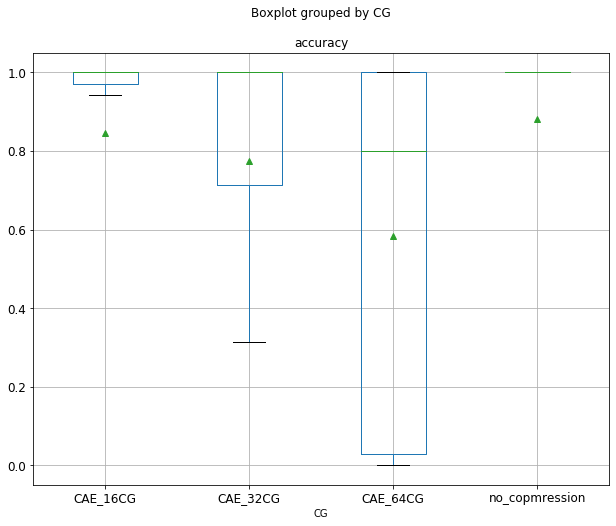

In [24]:
bp = df.boxplot('accuracy',by='CG',return_type='both',showmeans=True,showfliers=False,fontsize=12,figsize=(10,8))

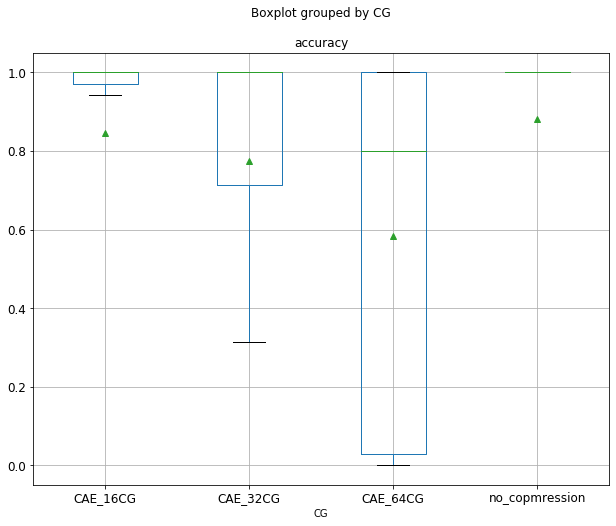

In [25]:
bp = df.boxplot('accuracy',by='CG',return_type='both',showmeans=True,showfliers=False,fontsize=12,figsize=(10,8))

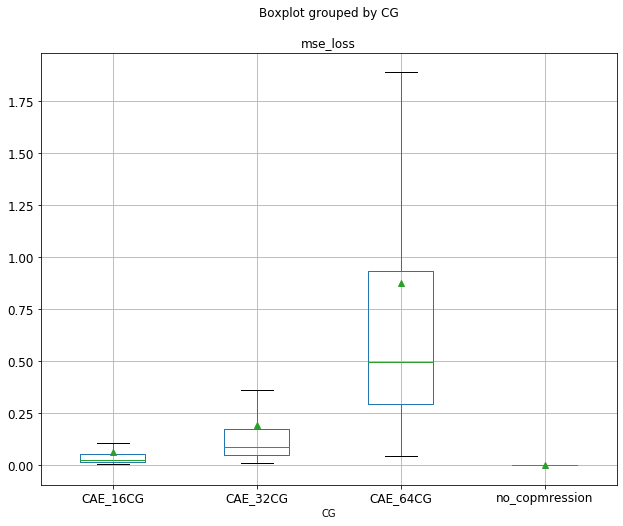

In [26]:
bp = df.boxplot('mse_loss',by='CG',return_type='both',showmeans=True,showfliers=False,fontsize=12,figsize=(10,8))

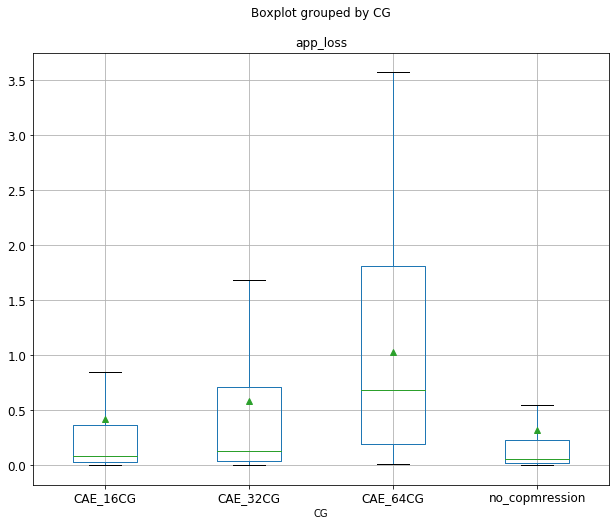

In [27]:
bp = df.boxplot('app_loss',by='CG',return_type='both',showmeans=True,showfliers=False,fontsize=12,figsize=(10,8))

In [28]:
df.head()


,signal_idx,signal,accuracy,mse_loss,app_loss,CG,STD,Entropy,amp_size,CG_int
0,0,"[[-1.298051], [-1.5587167], [-1.8235866], [-2.0758436], [-2.2314022], [-2.2944665], [-2.3154879], [-2.2944665], [-2.2524235], [-2.2019722], [-2.138908], [-2.0716393], [-2.021188], [-1.9833494], [-1.9455109], [-1.903468], [-1.8572209], [-1.7983608], [-1.7310923], [-1.6638237], [-1.6301895], [-1.609168], [-1.5881467], [-1.5755337], [-1.5629209], [-1.5545124], [-1.5503081], [-1.5545124], [-1.5629209], [-1.5713295], [-1.5881467], [-1.609168], [-1.6343938], [-1.6596195], [-1.697458], [-1.7689309], [-1.8361994], [-1.8656294], [-1.8866508], [-1.8992637], [-1.9118766], [-1.9202851], [-1.9286937], [-1.9371023], [-1.9413066], [-1.9497151], [-1.9539194], [-1.9539194], [-1.9455109], [-1.9371023], [-1.9286937], [-1.9202851], [-1.9076723], [-1.8950595], [-1.8824465], [-1.8656294], [-1.8572209], [-1.8530166], [-1.8446081], [-1.8404037], [-1.8277909], [-1.815178], [-1.8025652], [-1.785748], [-1.7731352], [-1.7563181], [-1.7437052], [-1.7310923], [-1.7226838], [-1.7142752], [-1.7058666], [-1.7016623], [-1.6932538], [-1.6848452], [-1.6764367], [-1.6680281], [-1.6596195], [-1.6470066], [-1.6343938], [-1.621781], [-1.6049638], [-1.5965552], [-1.5839424], [-1.5755337], [-1.5629209], [-1.5503081], [-1.5292866], [-1.504061], [-1.4704267], [-1.4325881], [-1.3947495], [-1.3653196], [-1.3316853], [-1.3064595], [-1.2896425], [-1.2770296], [-1.2686211], [-1.2602124], [-1.2518039], [-1.239191], ...]",1.000000,0.0,0.014810,no_copmression,0.454987,5.353854,5.284785,1
1,1,"[[-0.07460427], [-0.07460427], [-0.07880855], [-0.07880855], [-0.08301284], [-0.09982998], [-0.15028138], [-0.15448567], [-0.09982998], [-0.0661957], [-0.04096999], [-0.019948568], [-0.0031314297], [0.005277139], [0.0010728549], [-0.011539998], [-0.028357137], [-0.057787128], [-0.11664712], [-0.23436709], [-0.34367847], [-0.4193556], [-0.4740113], [-0.50764555], [-0.5328713], [-0.5496884], [-0.5496884], [-0.5244627], [-0.47821558], [-0.40674275], [-0.2806142], [-0.15028138], [-0.04096999], [-0.011539998], [0.0010728549], [0.013685708], [0.022094278], [0.03470713], [0.047319986], [0.055728555], [0.06413712], [0.068341404], [0.072545685], [0.07674997], [0.07674997], [0.07674997], [0.07674997], [0.072545685], [0.072545685], [0.06413712], [0.05993284], [0.055728555], [0.047319986], [0.0431157], [0.0431157], [0.038911417], [0.03470713], [0.030502846], [0.026298562], [0.013685708], [-0.019948568], [-0.015744284], [0.055728555], [0.11879282], [0.1776528], [0.21969564], [0.24912563], [0.27435133], [0.30378133], [0.32480276], [0.3374156], [0.3416199], [0.3374156], [0.33321133], [0.32900703], [0.32480276], [0.32059848], [0.31639418], [0.32480276], [0.3374156], [0.35423276], [0.3668456], [0.37945846], [0.3920713], [0.40888846], [0.417297], [0.4215013], [0.4215013], [0.41309273], [0.39627558], [0.37525418], [0.34582418], [0.3121899], [0.26173848], [0.16924423], [0.1229971], [0.08515854], [0.05152427], [0.05993284], [0.1272014], ...]",0.000000,0.0,2.116578,no_copmression,0.438322,5.921943,4.069747,1
2,2,"[[0.05993284], [0.068341404], [0.08095425], [0.10197568], [0.17344852], [0.24492136], [0.29537275], [0.33321133], [0.35423276], [0.37525418], [0.38786703], [0.40047988], [0.40888846], [0.41309273], [0.417297], [0.4215013], [0.42570558], [0.43411416], [0.43831843], [0.44252273], [0.44252273], [0.446727], [0.446727], [0.45093128], [0.45093128], [0.45093128], [0.45093128], [0.45513558], [0.45513558], [0.45933986], [0.46354416], [0.46354416], [0.46774843], [0.476157], [0.48876986], [0.49297413], [0.48876986], [0.4719527], [0.43831843], [0.40047988], [0.35843703], [0.30378133], [0.2575342], [0.21549135], [0.19446994], [0.17344852], [0.16083567], [0.15242709], [0.14401853], [0.13140567], [0.11879282], [0.10197568], [0.08936282], [0.07674997], [0.05993284], [0.03470713], [-0.007335714], [-0.07880855], [-0.15448567], [-0.20493709], [-0.23857136], [-0.26800135], [-0.30163562], [-0.3394742], [-0.37731275], [-0.42355987], [-0.469807

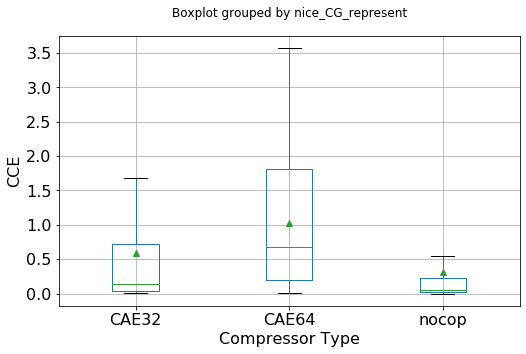

In [29]:
df['nice_CG_represent'] = df['CG'].apply(lambda x: x.replace('_','')[:5])
bp = df[df['CG_int']!=16].boxplot('app_loss',by='nice_CG_represent',return_type='both',showmeans=True,showfliers=False,fontsize=16,figsize=(8,5))
plt.title(' ',fontsize=15)
plt.xlabel('Compressor Type',fontsize=16)
plt.ylabel('CCE',fontsize=16)
plt.show()

In [30]:
df.describe()

,signal_idx,accuracy,mse_loss,app_loss,STD,Entropy,amp_size,CG_int
count,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000
mean,300.500000,0.771654,0.283496,0.588629,0.898321,6.083946,10.409753,28.250000
std,173.818287,0.381251,0.741258,0.889069,0.505268,0.452604,8.059036,23.375509
min,0.000000,0.000000,0.000000,0.000189,0.188437,4.701845,1.496725,1.000000
25%,150.000000,0.685714,0.002496,0.037115,0.582598,5.766875,5.415119,12.250000
50%,300.500000,1.000000,0.049069,0.143881,0.746263,6.067566,7.634981,24.000000
75%,451.000000,1.000000,0.251468,0.741533,1.071057,6.370994,12.436274,40.000000
max,601.000000,1.000000,14.615060,5.512460,4.029768,7.677316,58.338646,64.000000


In [31]:
num_of_samples = x_dev.shape[0]
# df = pd.read_csv('Data/CINC_banchmark.csv')
def adaptive_compression_accuracy(df, threshold_PRD,base_factor=1):
    """
    Measure by accuracy and decide based on the accuracy
    """
    df_threshold = df[df['accuracy']>threshold_PRD]
    indices = df_threshold.groupby('signal_idx',sort=False)['CG_int'].transform(max)==df_threshold['CG_int']
    
    if len(indices)==0:
        num_satisfied_PRD_indices = 0
        avg_acc = 1
        meanCG = base_factor

    else:
        num_satisfied_PRD_indices = indices.value_counts()[True]
        avg_acc = (num_satisfied_PRD_indices/num_of_samples)*df_threshold[indices]['accuracy'].mean()+((num_of_samples-num_satisfied_PRD_indices)/num_of_samples)*1
        meanCG = ((num_of_samples-num_satisfied_PRD_indices)/num_of_samples)*base_factor + (num_satisfied_PRD_indices/num_of_samples)*df_threshold[indices]['CG_int'].mean()
    
    return avg_acc,meanCG


def adaptive_compression_mse_accuracy(df, threshold_PRD,base_factor=1):
    """
    Measure by mse_loss and decide based on the accuracy
    """
    df_threshold = df[df['mse_loss']<threshold_PRD]
    indices = df_threshold.groupby('signal_idx',sort=False)['CG_int'].transform(max)==df_threshold['CG_int']
    
    if len(indices)==0:
        num_satisfied_PRD_indices = 0
        avg_acc = 0
        meanCG = base_factor

    else:
        num_satisfied_PRD_indices = indices.value_counts()[True]
        avg_acc = (num_satisfied_PRD_indices/num_of_samples)*df_threshold[indices]['accuracy'].mean()+((num_of_samples-num_satisfied_PRD_indices)/num_of_samples)*1
        meanCG = ((num_of_samples-num_satisfied_PRD_indices)/num_of_samples)*base_factor + (num_satisfied_PRD_indices/num_of_samples)*df_threshold[indices]['CG_int'].mean()
    
    return avg_acc,meanCG

def adaptive_compression_app_loss(df, threshold_PRD,base_factor=1):
    """
    Measure by app_loss and decide based on the app_loss
    """
    df_threshold = df[df['app_loss']<threshold_PRD]
    indices = df_threshold.groupby('signal_idx',sort=False)['CG_int'].transform(max)==df_threshold['CG_int']
    
    if len(indices)==0:
        num_satisfied_PRD_indices = 0
        avg_acc = 0
        meanCG = base_factor

    else:
        num_satisfied_PRD_indices = indices.value_counts()[True]
        avg_loss = (num_satisfied_PRD_indices/num_of_samples)*df_threshold[indices]['app_loss'].mean()+((num_of_samples-num_satisfied_PRD_indices)/num_of_samples)*0
        meanCG = ((num_of_samples-num_satisfied_PRD_indices)/num_of_samples)*base_factor + (num_satisfied_PRD_indices/num_of_samples)*df_threshold[indices]['CG_int'].mean()
    
    return avg_loss,meanCG


static_SOTA_64={'prd':[],'cg':[],'REAL_PRD':[]}
static_SOTA_32={'prd':[],'cg':[],'REAL_PRD':[]}
static_SOTA_16={'prd':[],'cg':[],'REAL_PRD':[]}
adap_cg_min1 = {'prd':[],'cg':[],'REAL_PRD':[]}
static_SOTA_64_mse={'prd':[],'cg':[],'REAL_PRD':[]}
static_SOTA_32_mse={'prd':[],'cg':[],'REAL_PRD':[]}
static_SOTA_16_mse={'prd':[],'cg':[],'REAL_PRD':[]}
adap_cg_min1_mse = {'prd':[],'cg':[],'REAL_PRD':[]}
static_SOTA_64_app_loss={'prd':[],'cg':[],'REAL_PRD':[]}
static_SOTA_32_app_loss={'prd':[],'cg':[],'REAL_PRD':[]}
static_SOTA_16_app_loss={'prd':[],'cg':[],'REAL_PRD':[]}
adap_cg_min1_app_loss = {'prd':[],'cg':[],'REAL_PRD':[]}

for customer_acc in np.arange(0.01,1,0.02):
#     static_SOTA_16['cg'].append(adaptive_compression_accuracy(df[df['CG_int']==16],acc,1)[1])
#     static_SOTA_32['cg'].append(adaptive_compression_accuracy(df[df['CG_int']==32],acc,1)[1])
# #     static_SOTA_64['cg'].append(adaptive_compression(df[df['CG_int']==64],PRD,1)[1])
#     adap_cg_min1['cg'].append(adaptive_compression_accuracy(df,acc,1)[1])
    
    acc,cg = adaptive_compression_accuracy(df[df['CG_int']==16],customer_acc,1)
    static_SOTA_16['prd'].append(acc)
    static_SOTA_16['cg'].append(cg)
    static_SOTA_16['REAL_PRD'].append(customer_acc)
    
    
    acc,cg = adaptive_compression_accuracy(df[df['CG_int']==32],customer_acc,1)
    static_SOTA_32['prd'].append(acc)
    static_SOTA_32['cg'].append(cg)
    static_SOTA_32['REAL_PRD'].append(customer_acc)
    
    acc,cg = adaptive_compression_accuracy(df[df['CG_int']==64],customer_acc,1)
    static_SOTA_64['prd'].append(acc)
    static_SOTA_64['cg'].append(cg)
    static_SOTA_64['REAL_PRD'].append(customer_acc)
    
    acc,cg = adaptive_compression_accuracy(df,customer_acc,1)
    adap_cg_min1['prd'].append(acc)
    adap_cg_min1['cg'].append(cg)
    adap_cg_min1['REAL_PRD'].append(customer_acc)

for app_loss in np.arange(0.1,2,0.1):
# #     static_SOTA_32_mse['cg'].append(adaptive_compression_mse_accuracy(df[df['CG_int']==32],PRD,1)[1])
# #     static_SOTA_16_mse['cg'].append(adaptive_compression_mse_accuracy(df[df['CG_int']==16],PRD,1)[1])
# #     static_SOTA_64['cg'].append(adaptive_compression(df[df['CG_int']==64],PRD,1)[1])
# #     adap_cg_min1_mse['cg'].append(adaptive_compression_mse_accuracy(df,PRD,1)[1])
    
# #     acc,cg = adaptive_compression_app_loss(df[df['CG_int']==16],real_prd,1)
# #     static_SOTA_16_mse['prd'].append(acc)
# #     static_SOTA_16_mse['cg'].append(cg)
# #     static_SOTA_16_mse['REAL_PRD'].append(real_prd)
    
    acc,cg = adaptive_compression_app_loss(df[df['CG_int']==16],app_loss,1)
    static_SOTA_16_app_loss['prd'].append(acc)
    static_SOTA_16_app_loss['cg'].append(cg)
    static_SOTA_16_app_loss['REAL_PRD'].append(app_loss)
    
    acc,cg = adaptive_compression_app_loss(df[df['CG_int']==32],app_loss,1)
    static_SOTA_32_app_loss['prd'].append(acc)
    static_SOTA_32_app_loss['cg'].append(cg)
    static_SOTA_32_app_loss['REAL_PRD'].append(app_loss)
    
    acc,cg = adaptive_compression_app_loss(df[df['CG_int']==64],app_loss,1)
    static_SOTA_64_app_loss['prd'].append(acc)
    static_SOTA_64_app_loss['cg'].append(cg)
    static_SOTA_64_app_loss['REAL_PRD'].append(app_loss)
    
    acc,cg = adaptive_compression_app_loss(df[df['CG_int']>16],app_loss,1)
    adap_cg_min1_app_loss['prd'].append(acc)
    adap_cg_min1_app_loss['cg'].append(cg)
    adap_cg_min1_app_loss['REAL_PRD'].append(app_loss)


for mse_loss in np.arange(0.05,1,0.05):
#     static_SOTA_32_mse['cg'].append(adaptive_compression_mse_accuracy(df[df['CG_int']==32],PRD,1)[1])
#     static_SOTA_16_mse['cg'].append(adaptive_compression_mse_accuracy(df[df['CG_int']==16],PRD,1)[1])
#     static_SOTA_64['cg'].append(adaptive_compression(df[df['CG_int']==64],PRD,1)[1])
#     adap_cg_min1_mse['cg'].append(adaptive_compression_mse_accuracy(df,PRD,1)[1])
    
    acc,cg = adaptive_compression_mse_accuracy(df[df['CG_int']==16],mse_loss,1)
    static_SOTA_16_mse['prd'].append(acc)
    static_SOTA_16_mse['cg'].append(cg)
    static_SOTA_16_mse['REAL_PRD'].append(mse_loss)
    
    acc,cg = adaptive_compression_mse_accuracy(df[df['CG_int']==32],mse_loss,1)
    static_SOTA_32_mse['prd'].append(acc)
    static_SOTA_32_mse['cg'].append(cg)
    static_SOTA_32_mse['REAL_PRD'].append(mse_loss)
    
    acc,cg = adaptive_compression_mse_accuracy(df[df['CG_int']==64],mse_loss,1)
    static_SOTA_64_mse['prd'].append(acc)
    static_SOTA_64_mse['cg'].append(cg)
    static_SOTA_64_mse['REAL_PRD'].append(mse_loss)
    
    acc,cg = adaptive_compression_mse_accuracy(df,mse_loss,1)
    adap_cg_min1_mse['prd'].append(acc)
    adap_cg_min1_mse['cg'].append(cg)
    adap_cg_min1_mse['REAL_PRD'].append(mse_loss)

    

Text(0.5, 1.0, 'Adaptive CG as func of HR accuracy - residue based decision')

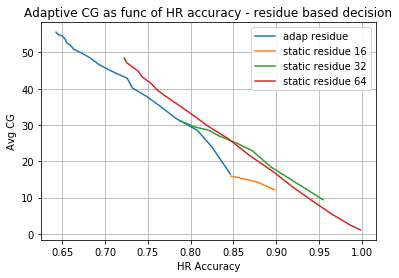

In [32]:
plt.plot(adap_cg_min1_mse['prd'],adap_cg_min1_mse['cg'])
plt.plot(static_SOTA_16_mse['prd'],static_SOTA_16_mse['cg'])
plt.plot(static_SOTA_32_mse['prd'],static_SOTA_32_mse['cg'])
plt.plot(static_SOTA_64_mse['prd'],static_SOTA_64_mse['cg'])
plt.legend(['adap residue','static residue 16','static residue 32','static residue 64'])
# plt.yticks(np.arange(0, 65, 5))
plt.xlabel('HR Accuracy')
plt.ylabel('Avg CG')
plt.grid()
plt.title('Adaptive CG as func of HR accuracy - residue based decision')

Text(0.5, 1.0, 'Adaptive CG as func of HR accuracy (against max residue)')

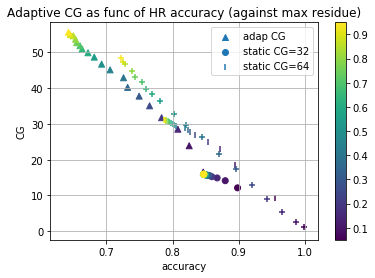

In [33]:
sc = plt.scatter(adap_cg_min1_mse['prd'],adap_cg_min1_mse['cg'],c=adap_cg_min1_mse['REAL_PRD'],marker='^')
plt.scatter(static_SOTA_16_mse['prd'],static_SOTA_16_mse['cg'],c=static_SOTA_16_mse['REAL_PRD'],marker='o')
plt.scatter(static_SOTA_32_mse['prd'],static_SOTA_32_mse['cg'],c=static_SOTA_32_mse['REAL_PRD'],marker='|')
plt.scatter(static_SOTA_64_mse['prd'],static_SOTA_64_mse['cg'],c=static_SOTA_64_mse['REAL_PRD'],marker='+')
plt.legend(['adap CG','static CG=16','static CG=32','static CG=64'])
plt.legend(['adap CG','static CG=32','static CG=64'])
plt.xlabel('accuracy')
plt.colorbar(sc)
plt.ylabel('CG')
plt.grid()
plt.title('Adaptive CG as func of HR accuracy (against max residue)')

Text(0.5, 1.0, 'Adaptive CG as func of HR accuracy')

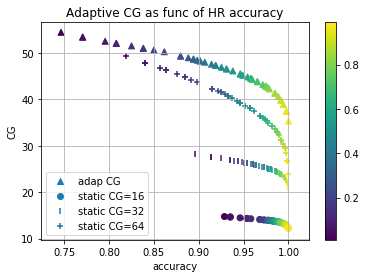

In [34]:
sc = plt.scatter(adap_cg_min1['prd'],adap_cg_min1['cg'],c=adap_cg_min1['REAL_PRD'],marker='^')
plt.scatter(static_SOTA_16['prd'],static_SOTA_16['cg'],c=static_SOTA_16['REAL_PRD'],marker='o')
plt.scatter(static_SOTA_32['prd'],static_SOTA_32['cg'],c=static_SOTA_32['REAL_PRD'],marker='|')
plt.scatter(static_SOTA_64['prd'],static_SOTA_64['cg'],c=static_SOTA_64['REAL_PRD'],marker='+')
plt.legend(['adap CG','static CG=16','static CG=32','static CG=64'])
plt.xlabel('accuracy')
plt.colorbar(sc)
plt.ylabel('CG')
plt.grid()
plt.title('Adaptive CG as func of HR accuracy')

Text(0.5, 1.0, 'Adaptive CG as func of HR accuracy decision based')

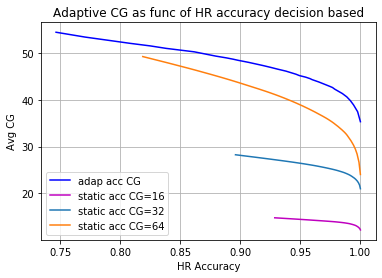

In [35]:
plt.plot(adap_cg_min1['prd'],adap_cg_min1['cg'],'b')
plt.plot(static_SOTA_16['prd'],static_SOTA_16['cg'],'m')
plt.plot(static_SOTA_32['prd'],static_SOTA_32['cg'])
plt.plot(static_SOTA_64['prd'],static_SOTA_64['cg'])

plt.legend(['adap acc CG','static acc CG=16','static acc CG=32','static acc CG=64'])#,'adap residue','static residue 16','static residue 32','static residue 64'])
plt.xlabel('HR Accuracy')
plt.ylabel('Avg CG')
plt.grid()
plt.title('Adaptive CG as func of HR accuracy decision based')

Text(0.5, 1.0, 'Adaptive CG as func of HR accuracy - app_loss based decision')

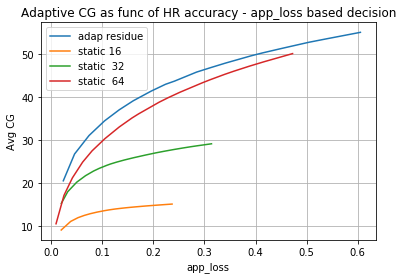

In [36]:
plt.plot(adap_cg_min1_app_loss['prd'],adap_cg_min1_app_loss['cg'])
plt.plot(static_SOTA_16_app_loss['prd'],static_SOTA_16_app_loss['cg'])
plt.plot(static_SOTA_32_app_loss['prd'],static_SOTA_32_app_loss['cg'])
plt.plot(static_SOTA_64_app_loss['prd'],static_SOTA_64_app_loss['cg'])
plt.legend(['adap residue','static 16','static  32','static  64'])
# plt.yticks(np.arange(0, 65, 5))
plt.xlabel('app_loss')
plt.ylabel('Avg CG')
plt.grid()
plt.title('Adaptive CG as func of HR accuracy - app_loss based decision')

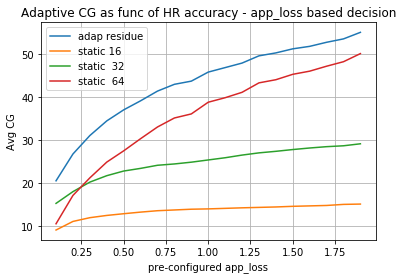

Text(0.5, 1.0, 'Adaptive CG as func of HR accuracy - app_loss based decision')

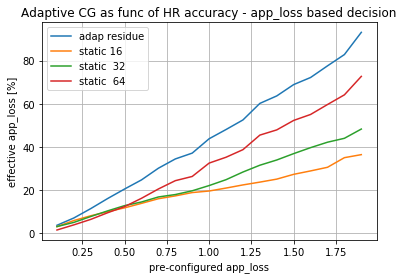

In [37]:
plt.plot(adap_cg_min1_app_loss['REAL_PRD'],adap_cg_min1_app_loss['cg'])
plt.plot(static_SOTA_16_app_loss['REAL_PRD'],static_SOTA_16_app_loss['cg'])
plt.plot(static_SOTA_32_app_loss['REAL_PRD'],static_SOTA_32_app_loss['cg'])
plt.plot(static_SOTA_64_app_loss['REAL_PRD'],static_SOTA_64_app_loss['cg'])
plt.legend(['adap residue','static 16','static  32','static  64'])
# plt.yticks(np.arange(0, 65, 5))
plt.xlabel('pre-configured app_loss')
plt.ylabel('Avg CG')
plt.grid()
plt.title('Adaptive CG as func of HR accuracy - app_loss based decision')
plt.show()
plt.plot(adap_cg_min1_app_loss['REAL_PRD'],np.array(adap_cg_min1_app_loss['prd'])/0.65*100)
plt.plot(static_SOTA_16_app_loss['REAL_PRD'],np.array(static_SOTA_16_app_loss['prd'])/0.65*100)
plt.plot(static_SOTA_32_app_loss['REAL_PRD'],np.array(static_SOTA_32_app_loss['prd'])/0.65*100)
plt.plot(static_SOTA_64_app_loss['REAL_PRD'],np.array(static_SOTA_64_app_loss['prd'])/0.65*100)
plt.legend(['adap residue','static 16','static  32','static  64'])
# plt.yticks(np.arange(0, 65, 5))
plt.xlabel('pre-configured app_loss')
plt.ylabel('effective app_loss [%]')
plt.grid()
plt.title('Adaptive CG as func of HR accuracy - app_loss based decision')

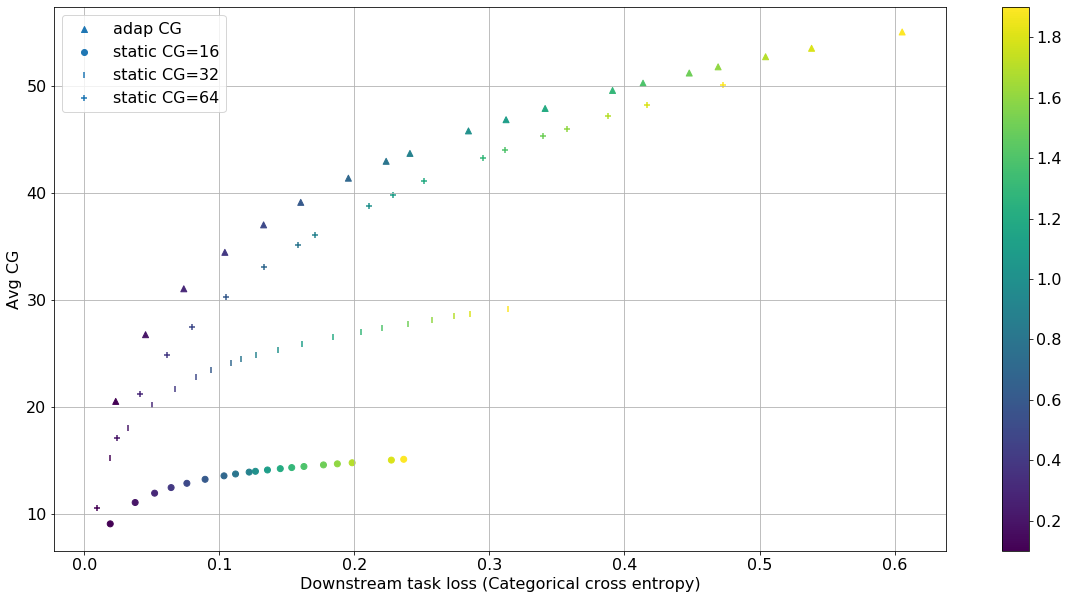

In [38]:
plt.figure(figsize=(20,10))
font = {'size'   : 16}
#69d color
plt.rc('font', **font)
sc = plt.scatter(adap_cg_min1_app_loss['prd'],adap_cg_min1_app_loss['cg'],c=adap_cg_min1_app_loss['REAL_PRD'],marker='^')
plt.scatter(static_SOTA_16_app_loss['prd'],static_SOTA_16_app_loss['cg'],c=static_SOTA_16_app_loss['REAL_PRD'],marker='o')
plt.scatter(static_SOTA_32_app_loss['prd'],static_SOTA_32_app_loss['cg'],c=static_SOTA_32_app_loss['REAL_PRD'],marker='|')
plt.scatter(static_SOTA_64_app_loss['prd'],static_SOTA_64_app_loss['cg'],c=static_SOTA_64_app_loss['REAL_PRD'],marker='+')
plt.legend(['adap CG','static CG=16','static CG=32','static CG=64'])
plt.colorbar(sc)
plt.xlabel('Downstream task loss (Categorical cross entropy)')
plt.ylabel('Avg CG')
plt.grid()
# plt.title('Adaptive CG as func of HR accuracy - app_loss based decision')

In [39]:
# plt.figure(figsize=(20,10))
# font = {'size'   : 16}
# #69d color
# plt.rc('font', **font)
# sc = plt.scatter(adap_cg_min1_app_loss['prd'],adap_cg_min1_app_loss['cg'],c=adap_cg_min1_app_loss['REAL_PRD'],marker='^')
# plt.scatter(static_SOTA_16_app_loss['prd'],static_SOTA_16_app_loss['cg'],c=static_SOTA_16_app_loss['REAL_PRD'],marker='o')
# plt.scatter(static_SOTA_32_app_loss['prd'],static_SOTA_32_app_loss['cg'],c=static_SOTA_32_app_loss['REAL_PRD'],marker='|')
# plt.scatter(static_SOTA_64_app_loss['prd'],static_SOTA_64_app_loss['cg'],c=static_SOTA_64_app_loss['REAL_PRD'],marker='+')
# plt.legend(['adap CG','static CG=16','static CG=32','static CG=64'])
# plt.colorbar(sc)
# plt.xlabel('Downstream task loss (Categorical cross entropy)')
# plt.ylabel('Avg CG')
# plt.grid()
# # plt.title('Adaptive CG as func of HR accuracy - app_loss based decision')

In [40]:
df.to_csv('Data/CINC_banchmark.csv')

In [41]:
raise

RuntimeError: No active exception to reraise

In [ ]:
df = pd.read_csv('Data/CINC_banchmark.csv')

In [ ]:
df[df['signal_idx']==10]

## Build Dataset

In [ ]:
def missing_values(df, col_name,upper_value):
    missing_values = []
    unique_values=df[col_name].unique()
    for i in range(upper_value):
        if not i in unique_values:
            missing_values.append(i)
    return missing_values

def buid_dataset(df,threshold_PRD):

    df_threshold = df[(df['accuracy']>threshold_PRD)]
    indices = df_threshold.groupby('signal_idx',sort=False)['CG_int'].transform(max)==df_threshold['CG_int']
    t = df_threshold[indices][['signal_idx','mse_loss','accuracy','CG_int']]

    no_compression_idx = missing_values(t,'signal_idx',int(df.shape[0]/len(df['CG_int'].unique())))
    no_compression_stats = pd.DataFrame([[x,0,1,1] for x in no_compression_idx])
    no_compression_stats.columns = ['signal_idx','mse_loss','accuracy','CG_int']
    t = pd.concat([no_compression_stats,t],axis=0)
#     print(t.shape)
    t['MIN_ACC'] = t['CG_int'].apply(lambda x: float(threshold_PRD))
    return t

def buid_dataset_by_apploss(df,threshold_appLoss):

    df_threshold = df[(df['app_loss'] < threshold_appLoss)]
    indices = df_threshold.groupby('signal_idx',sort=False)['CG_int'].transform(max)==df_threshold['CG_int']
    t = df_threshold[indices][['signal_idx','app_loss','accuracy','CG_int']]

    no_compression_idx = missing_values(t,'signal_idx',int(df.shape[0]/len(df['CG_int'].unique())))
    no_compression_stats = pd.DataFrame([[x,0,1,1] for x in no_compression_idx])
    no_compression_stats.columns = ['signal_idx','app_loss','accuracy','CG_int']
    t = pd.concat([no_compression_stats,t],axis=0)
#     print(t.shape)
    t['MAX_LOSS'] = t['CG_int'].apply(lambda x: float(threshold_appLoss))
    return t

t = buid_dataset_by_apploss(df,0.1)
idx = 0
for app_loss in np.arange(0.2,2,0.1):
#     df_threshold = df[(df['PRD']<PRD) & (df['CG_int']<64)]
#     indices = df_threshold.groupby('signal_idx',sort=False)['CG_int'].transform(max)==df_threshold['CG_int']
#     temp = df_threshold[indices][['signal_idx','PRD','CG_int']]
#     temp['MAX_PRD'] = pd.Series(np.ones(x_train.shape[0])*PRD)
    tempo = buid_dataset_by_apploss(df,app_loss)
    t = pd.concat([tempo,t])
    idx+=1
    
print(idx)

In [ ]:
np.arange(0.2,2,0.1)

In [ ]:
df.describe()

In [ ]:
t.describe()

In [ ]:
t.to_csv('Data/compressor_decsision_AppLoss.csv')

## ACC & Residue Corelation

In [ ]:
params_config['loss_weights']=[0.4,0.4]

In [ ]:
CAE_32 = network_compression.init_compress_app_network(network_compression.build_comression_network_32CG,'',params_config,compile=True,u_net=False)
CAE_32.load_weights('Models/GoodModels/CAE_CINC17CG32_loss-0.355-ACC-0.772.hdf5')

In [ ]:
# thesis/Data/compressor_decsision.csv
df = pd.read_csv('Data/CINC_banchmark.csv')
df.head()

In [ ]:
x_dev_recons = CAE_32.predict(x_dev)[0]
normed_mse = []
for i in range(len(x_dev)):
    normed_mse.append(normalize_mse(x_dev[i],x_dev_recons[i])[2])
len(normed_mse)
CG_32_stats_df['norm_mse'] = normed_mse
CG_32_stats_df.head()

In [ ]:
CG_32_stats_df['norm_mse'] = normed_mse
CG_32_stats_df.head()

In [ ]:
df = CG_32_stats_df

In [ ]:
df[(df['CG_int']==32) & (df['mse_loss']>-1) & (df['mse_loss']<50)].describe()

In [ ]:
df[(df['CG_int']==32) & (df['mse_loss']>0.02) & (df['mse_loss']<0.5)].describe()

In [ ]:
df[(df['CG_int']==32)].hist('accuracy',bins=50)
df[(df['CG_int']==32)].hist('norm_mse',bins=50)

In [ ]:
df[(df['CG_int']==32) & (df['mse_loss']>0.02) & (df['mse_loss']<0.5) & (df['accuracy']<0.99)].hist('accuracy',bins=50)
df[(df['CG_int']==32) & (df['mse_loss']>0.02) & (df['mse_loss']<0.5) & (df['accuracy']<0.99)].hist('mse_loss',bins=50)

In [ ]:
# accuracy = df[(df['CG_int']==32) & (df['mse_loss']>0) & (df['mse_loss']<2) & (df['accuracy']<1.99)]['accuracy']
# mse_loss = df[(df['CG_int']==32) & (df['mse_loss']>0) & (df['mse_loss']<2) & (df['accuracy']<1.99)]['mse_loss']
accuracy = df[(df['CG_int']==32)& (df['norm_mse']<0.008)]['accuracy']
mse_loss = df[(df['CG_int']==32)& (df['norm_mse']<0.008)]['norm_mse']
plt.scatter(mse_loss,accuracy)
plt.xlabel('norm_mse')
plt.ylabel('accuracy')

In [ ]:
app_loss = df[(df['CG_int']==32)& (df['norm_mse']<0.8)]['app_loss']
mse_loss = df[(df['CG_int']==32)& (df['norm_mse']<0.8)]['norm_mse']
plt.scatter(mse_loss,app_loss)
plt.xlabel('norm_mse')
plt.ylabel('app_loss')

In [ ]:
df[(df['CG_int']==32) & (df['norm_mse']>0.002) & (df['norm_mse']<0.008)].head(30)

In [ ]:
df[df['signal_idx']==3]

In [ ]:
from scipy.stats import pearsonr
from scipy.stats import spearmanr

from sklearn.metrics import normalized_mutual_info_score

In [ ]:
np.co

In [ ]:
#Pearson - Pearson’s coefficient measures linear correlation https://www.statlect.com/fundamentals-of-probability/linear-correlation
#Spearman - like pearson but take a look at the ranking - that way we can measure more simply the monotonic properties https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient
#normalized mutual information - 

print('\n**correlation mse_loss and accuracy')
corr, _ = pearsonr(df[(df['CG_int']==32)]['mse_loss'].values, df[df['CG_int']==32]['accuracy'].values)
print('Pearsons correlation: %.3f' % corr)
corr, _ = spearmanr(df[(df['CG_int']==32)]['mse_loss'].values, df[df['CG_int']==32]['accuracy'].values)
print('Spearmans correlation: %.3f' % corr)

print('\n**correlation norm_mse and accuracy')
corr, _ = pearsonr(df[(df['CG_int']==32)]['norm_mse'].values, df[df['CG_int']==32]['accuracy'].values)
print('Pearsons correlation: %.3f' % corr)
corr, _ = spearmanr(df[(df['CG_int']==32)]['norm_mse'].values, df[df['CG_int']==32]['accuracy'].values)
print('Spearmans correlation: %.3f' % corr)

print('\n**correlation mse_loss and app_loss')
corr, _ = pearsonr(df[(df['CG_int']==32)]['mse_loss'].values, df[df['CG_int']==32]['app_loss'].values)
print('Pearsons correlation: %.3f' % corr)
corr, _ = spearmanr(df[(df['CG_int']==32)]['mse_loss'].values, df[df['CG_int']==32]['app_loss'].values)
print('Spearmans correlation: %.3f' % corr)

print('\n**correlation norm_mse and app_loss')
corr, _ = pearsonr(df[(df['CG_int']==32)]['norm_mse'].values, df[df['CG_int']==32]['app_loss'].values)
print('Pearsons correlation: %.3f' % corr)
corr, _ = spearmanr(df[(df['CG_int']==32)]['norm_mse'].values, df[df['CG_int']==32]['app_loss'].values)
print('Spearmans correlation: %.3f' % corr)

print('\n**correlation accuracy and app_loss')
corr, _ = pearsonr(df[(df['CG_int']==32)]['accuracy'].values, df[df['CG_int']==32]['app_loss'].values)
print('Pearsons correlation: %.3f' % corr)
corr, _ = spearmanr(df[(df['CG_int']==32)]['accuracy'].values, df[df['CG_int']==32]['app_loss'].values)
print('Spearmans correlation: %.3f' % corr)


# Normalized mutual information
# print(normalized_mutual_info_score(df[(df['CG_int']==32)]['app_loss'].values, df[df['CG_int']==32]['norm_mse'].values))
# normalized_mutual_info_score(df[(df['CG_int']==32)]['accuracy'].values, df[df['CG_int']==32]['norm_mse'].values)

In [ ]:
# print('\n**correlation mse_loss and app_loss')
# corr, _ = pearsonr(df[(df['CG_int']==32)]['mse_loss'].values[:301], df[(df['CG_int']==32)]['mse_loss'].values[301:])
# print('Pearsons correlation: %.3f' % corr)
# corr, _ = spearmanr(df[(df['CG_int']==32)]['mse_loss'].values[:301], df[(df['CG_int']==32)]['mse_loss'].values[301:])
# print('Spearmans correlation: %.3f' % corr)

In [ ]:
def normalize_mse(signal_one,signal_two):
    signal_one = normelize_data(signal_one,0,1)
    signal_two = normelize_data(signal_two,0,1)
    return signal_one,signal_two,tf.keras.losses.mean_squared_error(signal_one[:,0],signal_two[:,0]).numpy()

In [ ]:
#    'MSE'        'ACC'
#51	 0.068144	0.914286	
#118 0.210998	0.914286
#4690 0.146381	0.914286	

low_range = 0
high_range = 80000
first_index = 595
snd_index=597

# corr, _ = pearsonr(x_dev[first_index][:,0], x_dev[snd_index][:,0])
# print('Pearsons correlation: %.3f' % corr)
# corr, _ = spearmanr(x_dev[first_index][:,0], x_dev[snd_index][:,0])
# print('Spearmans correlation: %.3f' % corr)

signal = x_dev[first_index][low_range:high_range]
predicted_signal = CAE_32.predict(x_dev[first_index].reshape(1,8960,1))[0][0][low_range:high_range]
signal,predicted_signal, mse_norm = normalize_mse(signal,predicted_signal)
plt.plot(signal)
plt.plot(predicted_signal)
print(df[(df['signal_idx']==first_index) & (df['CG_int']==32)][['accuracy','mse_loss']])
print("normalize mse:",mse_norm)
plt.show()

signal = x_dev[snd_index][low_range:high_range]
predicted_signal = CAE_32.predict(x_dev[snd_index].reshape(1,8960,1))[0][0][low_range:high_range]
signal,predicted_signal, mse_norm = normalize_mse(signal,predicted_signal)

plt.plot(signal)
plt.plot(predicted_signal)
print(df[(df['signal_idx']==snd_index) & (df['CG_int']==32)][['accuracy','mse_loss']])
print("normalize mse:",mse_norm)
plt.show()

In [ ]:
#    'MSE'        'ACC'
#51	 0.068144	0.914286	
#118 0.210998	0.914286
#4690 0.146381	0.914286	

low_range = 0
high_range = 2000
first_index = 59
snd_index=52

# corr, _ = pearsonr(x_dev[first_index][:,0], x_dev[snd_index][:,0])
# print('Pearsons correlation: %.3f' % corr)
# corr, _ = spearmanr(x_dev[first_index][:,0], x_dev[snd_index][:,0])
# print('Spearmans correlation: %.3f' % corr)

signal = x_dev[first_index][low_range:high_range]
predicted_signal = CAE_32.predict(x_dev[first_index].reshape(1,8960,1))[0][0][low_range:high_range]
signal,predicted_signal, mse_norm = normalize_mse(signal,predicted_signal)
plt.plot(signal)
plt.plot(predicted_signal)
print(df[(df['signal_idx']==first_index) & (df['CG_int']==32)][['accuracy','mse_loss']])
print("normalize mse:",mse_norm)
plt.show()

signal = x_dev[snd_index][low_range:high_range]
predicted_signal = CAE_32.predict(x_dev[snd_index].reshape(1,8960,1))[0][0][low_range:high_range]
signal,predicted_signal, mse_norm = normalize_mse(signal,predicted_signal)

plt.plot(signal)
plt.plot(predicted_signal)
print(df[(df['signal_idx']==snd_index) & (df['CG_int']==32)][['accuracy','mse_loss']])
print("normalize mse:",mse_norm)
plt.show()

In [ ]:
#    'MSE'        'ACC'
#51	 0.068144	0.914286	
#118 0.210998	0.914286
#4690 0.146381	0.914286	

low_range = 0
high_range = 4000
first_index = 36
snd_index=37

# corr, _ = pearsonr(x_dev[first_index][:,0], x_dev[snd_index][:,0])
# print('Pearsons correlation: %.3f' % corr)
# corr, _ = spearmanr(x_dev[first_index][:,0], x_dev[snd_index][:,0])
# print('Spearmans correlation: %.3f' % corr)

signal = x_dev[first_index][low_range:high_range]
predicted_signal = CAE_32.predict(x_dev[first_index].reshape(1,8960,1))[0][0][low_range:high_range]
signal,predicted_signal, mse_norm = normalize_mse(signal,predicted_signal)
plt.plot(signal)
plt.plot(predicted_signal)
print(df[(df['signal_idx']==first_index) & (df['CG_int']==32)][['accuracy','mse_loss']])
print("normalize mse:",mse_norm)
plt.show()

signal = x_dev[snd_index][low_range:high_range]
predicted_signal = CAE_32.predict(x_dev[snd_index].reshape(1,8960,1))[0][0][low_range:high_range]
signal,predicted_signal, mse_norm = normalize_mse(signal,predicted_signal)

plt.plot(signal)
plt.plot(predicted_signal)
print(df[(df['signal_idx']==snd_index) & (df['CG_int']==32)][['accuracy','mse_loss']])
print("normalize mse:",mse_norm)
plt.show()

In [ ]:
df[(df['CG_int']==32) & (df['mse_loss']>0.02) & (df['mse_loss']<0.5) & (df['accuracy']<0.5)].head()